<a href="https://colab.research.google.com/github/KelvinLam05/Binary-Classification-Ad-Click-Prediction/blob/main/customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

A growing proportion of what we buy regularly is purchased via a subscription, or some other kind of contract. Most people have contracts for their internet, mobile phone, car insurance, tax, iCloud, Spotify, and pretty much anything else we can think of. Even their milk.

To help maximise customer retention, contractual or subscription-based businesses, identify customers who are reaching the ends of their contracts and assess their probability to churn, or not renew, using a customer churn model. Rather than simply using the contract renewal date, these churn models assess other features that are associated with a customer’s propensity to renew their contract, or go elsewhere. 

In this project, we will build a contractual churn model for contractual settings to show how it’s done. 

**Load the packages**

In [1182]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [1183]:
pd.set_option('max_rows', 200)
pd.set_option('max_colwidth', 200)

**Load the data**

In [1184]:
# Load dataset
df = pd.read_csv('/content/customer_churn_prediction.csv')

In [1185]:
# Examine the data
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [1186]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

**Examine the data**

If we run the Pandas value_counts( ) function we will see that this is an imbalanced dataset. 

In [1187]:
df['churn'].value_counts()

no     3652
yes     598
Name: churn, dtype: int64

Since we are aiming for our model to predict customer churn, we need to set this as our target variable for the model to predict. At the moment, the churn column contains a boolean yes or no value, but we need to “binarise” this to turn it into a numeric value the model can use. A simple replace( ) is one of several ways to do this.

In [1188]:
df['churn'] = df['churn'].replace(('yes', 'no'), (1, 0))

**Check for missing values**

In [1189]:
df.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

We don’t have any missing data. We are good to go.

**Examine categorical data cardinality**

Next we will take a look at the “cardinality” of the categorical variables. Cardinality is just a technical way of saying the number of unique values held within. Columns with low cardinality, such as area_code, international_plan, and voice_mail_plan can be treated differently to the state column which has a high cardinality of 51.

In [1190]:
df.select_dtypes(include = ['object']).agg(['count', 'nunique']).T

,count,nunique
state,4250,51
area_code,4250,3
international_plan,4250,2
voice_mail_plan,4250,2


**Feature engineering**

The international_plan and voice_mail_plan columns are currently set to Boolean values, so we first need to binarise these, which we can do with the replace( ) function.

In [1191]:
df['international_plan'] = df['international_plan'].replace(('yes', 'no'), (1, 0))
df['voice_mail_plan'] = df['voice_mail_plan'].replace(('yes', 'no'), (1, 0))

We can also do some maths and calculate the call charge rate for each customer to see if this can help improve the model’s predictions. Maybe customers faced with higher charges are more likely to churn? To calculate the call charge rate, I have created a little function that divides the charges by the number of minutes and then assigns the values to a new column. We will use this approach for day, night, international, and evening call charges.

In [1192]:
def call_charge_rate(df, minutes_column, charges_column):
    
    return df[charges_column] / df[minutes_column]

In [1193]:
df['charge_rate_day'] = call_charge_rate(df, 'total_day_minutes', 'total_day_charge')
df['charge_rate_night'] = call_charge_rate(df, 'total_night_minutes', 'total_night_charge')
df['charge_rate_intl'] = call_charge_rate(df, 'total_intl_minutes', 'total_intl_charge')
df['charge_rate_eve'] = call_charge_rate(df, 'total_eve_minutes', 'total_eve_charge')

In [1194]:
df = df.fillna(0)

Next, we will use a clever technique called mean encoding. This is often very powerful. It works by calculating the mean of the target variable for a given group. For example, what is the mean churn rate for customers by state? Are those in some states more likely to churn that others? We can use the same technique for other columns where there’s a natural grouping, such as the customers on the international plan and the voice mail plan.

In [1195]:
def get_mean_encoding(df, group, target):

    mean_encoded = df.groupby(group)[target].mean()
    
    return df[group].map(mean_encoded)

In [1196]:
df['mean_encoded_state'] = get_mean_encoding(df, 'state', 'churn')
df['mean_encoded_international_plan'] = get_mean_encoding(df, 'international_plan', 'churn')
df['mean_encoded_voice_mail_plan'] = get_mean_encoding(df, 'voice_mail_plan', 'churn')

In [1197]:
import pandas.util.testing as tm
import category_encoders as ce

In [1198]:
encoder = ce.BinaryEncoder(cols = ['state'])
df = encoder.fit_transform(df)
df.head()

,state_0,state_1,state_2,state_3,state_4,state_5,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,charge_rate_day,charge_rate_night,charge_rate_intl,charge_rate_eve,mean_encoded_state,mean_encoded_international_plan,mean_encoded_voice_mail_plan
0,0,0,0,0,0,1,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.169988,0.045008,0.270073,0.085013,0.126316,0.111832,0.073741
1,0,0,0,0,1,0,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.170008,0.045018,0.269672,0.084983,0.270833,0.111832,0.164436
2,0,0,0,0,0,1,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0.170007,0.044997,0.269697,0.084976,0.126316,0.421717,0.164436
3,0,0,0,0,1,1,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0.170006,0.044997,0.270297,0.085030,0.205128,0.421717,0.164436
4,0,0,0,1,0,0,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0.169982,0.045014,0.270667,0.084993,0.157303,0.111832,0.073741


In [1199]:
encoder = ce.OneHotEncoder(cols = ['area_code'], use_cat_names = True)
df = encoder.fit_transform(df)
df.head()

,state_0,state_1,state_2,state_3,state_4,state_5,account_length,area_code_area_code_415,area_code_area_code_408,area_code_area_code_510,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,charge_rate_day,charge_rate_night,charge_rate_intl,charge_rate_eve,mean_encoded_state,mean_encoded_international_plan,mean_encoded_voice_mail_plan
0,0,0,0,0,0,1,107,1,0,0,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.169988,0.045008,0.270073,0.085013,0.126316,0.111832,0.073741
1,0,0,0,0,1,0,137,1,0,0,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.170008,0.045018,0.269672,0.084983,0.270833,0.111832,0.164436
2,0,0,0,0,0,1,84,0,1,0,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0.170007,0.044997,0.269697,0.084976,0.126316,0.421717,0.164436
3,0,0,0,0,1,1,75,1,0,0,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0.170006,0.044997,0.270297,0.085030,0.205128,0.421717,0.164436
4,0,0,0,1,0,0,121,0,0,1,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0.169982,0.045014,0.270667,0.084993,0.157303,0.111832,0.073741


**Examine correlations with the target variable**

Now we have converted most of our text-based features into numeric ones, and created some new features using our analysis of the data, we can examine which ones are most correlated with customer churn. To do this, I have used the Pandas corr( ) function, which creates a Pearson correlation and returns the coefficient for each column against our target column.

One important thing to note from the data below is that there’s also some collinearity. Some of the features, such as mean_encoded_international_plan and international_plan have equal correlations. That means one of them is redundant and could be removed with no impact to the model. 

In [1200]:
df[df.columns[1:]].corr()['churn'][:].sort_values(ascending = False).to_frame()

,churn
churn,1.000000
mean_encoded_international_plan,0.259053
international_plan,0.259053
number_customer_service_calls,0.221220
total_day_minutes,0.215272
total_day_charge,0.215263
mean_encoded_state,0.142246
mean_encoded_voice_mail_plan,0.114643
total_eve_minutes,0.078855
total_eve_charge,0.078852


**Featurewiz**

As we saw earlier, there are some collinear features present, so adopting a technique such as Featurewiz could see the score go up.

In [1201]:
from featurewiz import featurewiz

In [1202]:
target = 'churn'

Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (4250, 34)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    33 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
GPU active on this device
    Running XGBoost using GPU parameters
Removing 0 columns from further processing since ID or low information variables
    columns removed: []
    After removing redundant variables from further processing, features left = 33
#### Single_Label Binary_Classification Feature Selection Started ####
Searching for highly correlated variables from 33 variables using SULOV method
#####  SULOV : Searching for Uncorrelated List Of Variables (takes time...) #

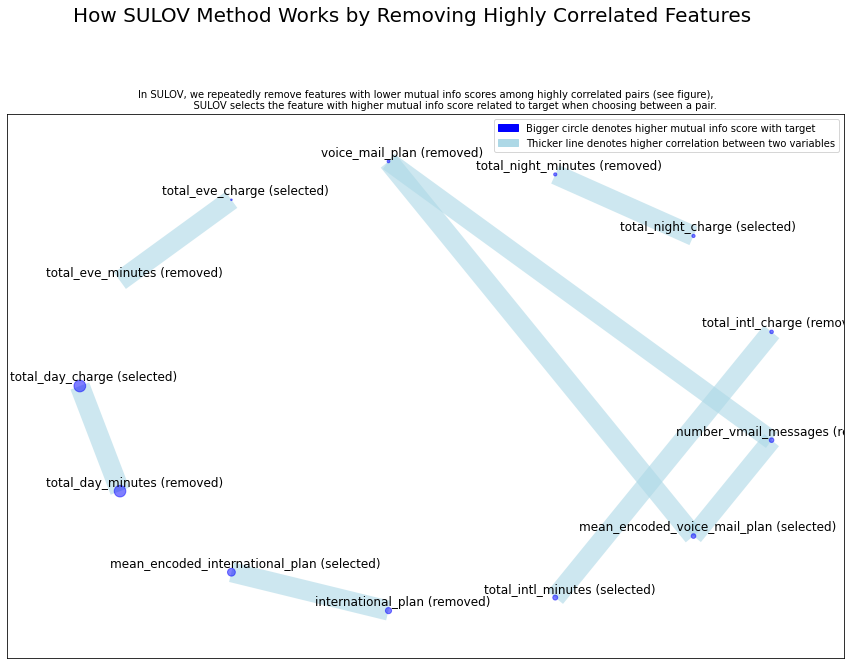

    Adding 0 categorical variables to reduced numeric variables  of 26
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 26 
    Finding Important Features using Boosted Trees algorithm...
        using 26 variables...
        using 21 variables...
        using 16 variables...
        using 11 variables...
        using 6 variables...
        using 1 variables...
Selected 13 important features from your dataset
    Time taken (in seconds) = 6
Returning list of 13 important features and dataframe.


In [1203]:
features, df = featurewiz(df, target, corr_limit = 0.8, verbose = 2)

As we can see, Featurewiz selects 13 important features from the dataset. The Featurewiz instance returns two objects 

* Features - a list of selected features

* One dataframe - This dataframe contains only selected features and the target variable.

Let see the list of selected features.

In [1283]:
features

['number_customer_service_calls',
 'mean_encoded_international_plan',
 'mean_encoded_voice_mail_plan',
 'total_day_charge',
 'total_intl_calls',
 'total_eve_charge',
 'total_intl_minutes',
 'area_code_area_code_415',
 'total_night_charge',
 'mean_encoded_state',
 'charge_rate_day',
 'charge_rate_night',
 'charge_rate_eve']

Upon inspecting the correlation heatmap of the df, it was clear that no collinear features were selected. 

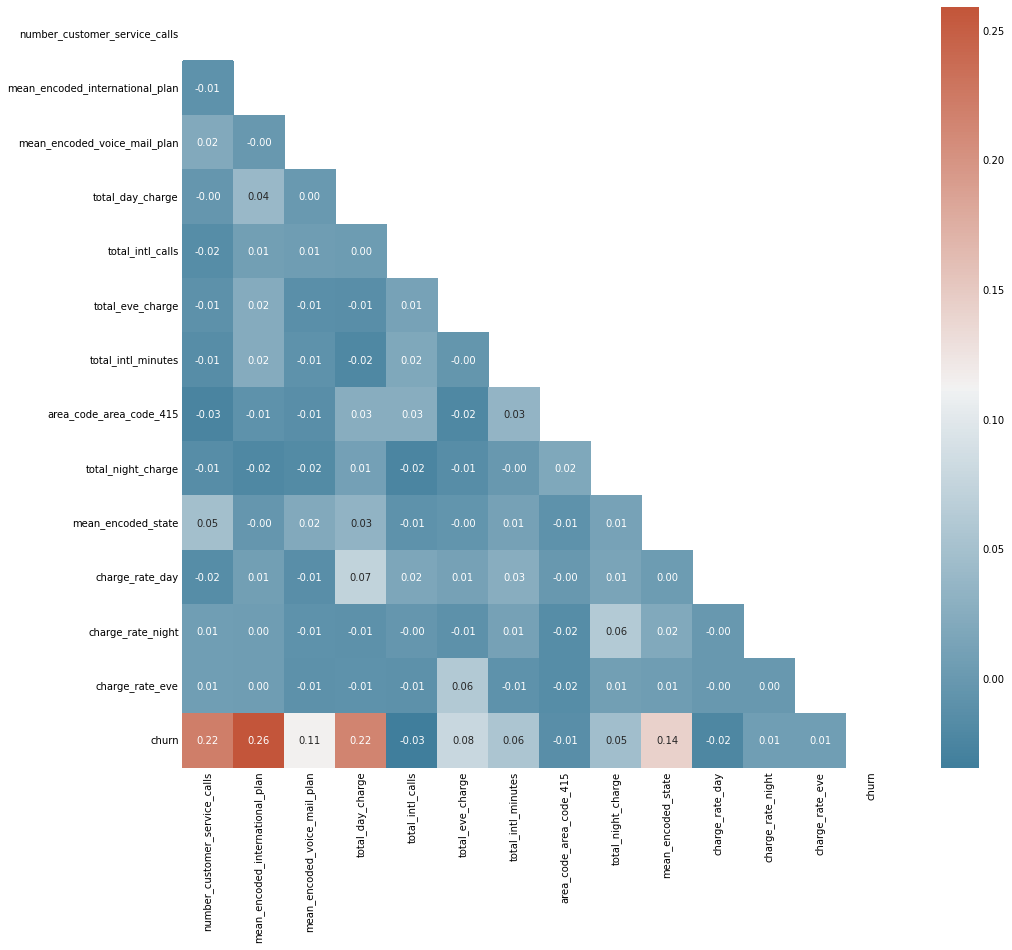

In [1205]:
corr = df.corr()
f, ax = plt.subplots(figsize = (16, 14))
mask = np.triu(np.ones_like(corr, dtype = bool))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
ax = sns.heatmap(corr, annot = True, fmt = '.2f', mask = mask, cmap = cmap)
ax.tick_params(axis = 'both', which = 'both', length = 0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(size = 0)

**Feature selection**

The next step is to take our original dataframe and create the X dataset of features and the y dataset containing the target variable. We will be training the model on X so it must not include anything that causes “data leakage” and tells the model the answer, so we definitely need to drop the target variable column.

In [1206]:
X = df.drop(['churn'], axis = 1)

In [1207]:
y = df['churn']

**SMOTE-ENN**

Next, we need to deal with the class imbalance in this data set. To help the model identify the relationships, we can use the SMOTE-ENN. This introduces new data on the target variable to balance the classes.

In [1208]:
from imblearn.combine import SMOTEENN

In [1209]:
smote = SMOTEENN(random_state = 42)
X, y = smote.fit_resample(X, y)

In [1210]:
y.value_counts()

1    3447
0    2543
Name: churn, dtype: int64

**Split the training and test data**

To divide X and y into the train and test datasets we need to train the model we will use the train_test_split( ) function from scikit-learn. We will assign 20% of the data to the test groups using the argument test_size = 0.2, and we will use the stratify = y option to ensure the target variable is present in the test and train data in equal proportions. The random_state = 42 argument means we get reproducible results each time we run the code, rather than a random mix, which may give us different results.

In [1211]:
from sklearn.model_selection import train_test_split

In [1212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

**Scale the data**

To help improve the model results, it’s worth using a scaling or normalisation technique on the data.

In [1213]:
from sklearn.preprocessing import StandardScaler

In [1214]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Model selection**

Next we need to identify the best model to use. To perform this step I have loaded up a range of packages for a wide range of different classification models, then I have created a dictionary containing the model name and the default model parameters.

In [1215]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [1216]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [1217]:
classifiers = {'DummyClassifier': DummyClassifier(strategy = 'most_frequent'),
               'XGBClassifier': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic'),
               'LogisticRegression': LogisticRegression(max_iter = 1000),
               'LGBMClassifier': LGBMClassifier(),
               'RandomForestClassifier': RandomForestClassifier(),
               'DecisionTreeClassifier': DecisionTreeClassifier(),
               'ExtraTreeClassifier': ExtraTreesClassifier(),
               'GradientBoostingClassifier': GradientBoostingClassifier(),    
               'BaggingClassifier': BaggingClassifier(),
               'AdaBoostClassifier': AdaBoostClassifier(),
               'HistGradientBoostingClassifier': HistGradientBoostingClassifier(),
               'KNeighborsClassifier': KNeighborsClassifier(),
               'SGDClassifier': SGDClassifier(),
               'BaggingClassifier': BaggingClassifier(),
               'BernoulliNB': BernoulliNB(),
               'LinearSVC': LinearSVC(),
               'SVC': SVC(),
               'CatBoostClassifier': CatBoostClassifier(silent = True)}

Next we will create a Pandas dataframe into which we will store the data. Then we will loop over each of the models, fit it using the X_train and y_train data, then generate predictions from X_test and calculate the mean ROC/AUC score from 5 rounds of cross-validation. That will give us the ROC/AUC score for the X_test data, plus the average ROC/AUC score for the training data set.

In [1218]:
df_models = pd.DataFrame(columns = ['model', 'run_time', 'roc_auc_cv', 'roc_auc'])

for key in classifiers:

    print('*', key)

    start_time = time.time()

    classifier = classifiers[key]
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'roc_auc')

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60, 2)),
           'roc_auc_cv': scores.mean(),
           'roc_auc': roc_auc_score(y_test, y_pred)}

    df_models = df_models.append(row, ignore_index = True)

* DummyClassifier
* XGBClassifier
* LogisticRegression
* LGBMClassifier
* RandomForestClassifier
* DecisionTreeClassifier
* ExtraTreeClassifier
* GradientBoostingClassifier
* BaggingClassifier
* AdaBoostClassifier
* HistGradientBoostingClassifier
* KNeighborsClassifier
* SGDClassifier
* BernoulliNB
* LinearSVC
* SVC
* CatBoostClassifier


Examining the output from the model selection step shows that we achieved very good results. The XGBoost classifier performed particularly well.

In [1219]:
df_models.sort_values(by = 'roc_auc_cv', ascending = False).head()

,model,run_time,roc_auc_cv,roc_auc
3,LGBMClassifier,0.03,0.994362,0.983477
16,CatBoostClassifier,0.44,0.994156,0.977884
10,HistGradientBoostingClassifier,0.06,0.993975,0.983008
1,XGBClassifier,0.13,0.993928,0.984415
6,ExtraTreeClassifier,0.04,0.993053,0.971902


**Assess the best model**

Now, we will use XGBoost’s XGBClassifier to create a classification model and we will fit the model using the data stored in X_train and y_train.

In [1274]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Finally, we can use our model trained on the training data to make predictions on the test dataset using the predict( ) function.

In [1275]:
y_pred = model.predict(X_test)

To examine how well the model performed in a little more detail we can make use of the classification_report( ) and confusion_matrix( ) functions. The classification report shows us the precision, recall, and F1 score for our predictions.

In [1276]:
from sklearn.metrics import classification_report

In [1277]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       509
           1       0.99      0.98      0.99       689

    accuracy                           0.98      1198
   macro avg       0.98      0.98      0.98      1198
weighted avg       0.98      0.98      0.98      1198



The confusion matrix shows us that:

* 502 true negatives (the customers didn’t churn, and we predicted this correctly)

* 677 true positives (the customers did churn, and we predicted this correctly)

* 7 false positives (the customers didn’t churn, but we wrongly predicted that they would)

* 12 false negatives (the customers did churn, but we wrongly predicted that they wouldn’t)

Out of 1198 predictions, we got it right 1179 times, and we got it wrong just 19 times.

In [1279]:
from sklearn.metrics import ConfusionMatrixDisplay

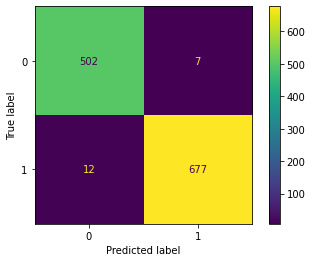

In [1280]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)